# Forecasting Hospital Admissions Using Particle Filtering

### Scenario

We can use `epymorph`'s built in particle filter to fit a data set and then run an ensemble forecast from the last data point.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from epymorph.kit import *
from epymorph.adrio import acs5

from epymorph.adrio import us_tiger

from epymorph.forecasting.pipeline import (
    FromRUME,FromOutput,
    ParticleFilterSimulator,
    ForecastSimulator,
    EnsembleKalmanFilterSimulator,
    Observations,
    ModelLink,
    UnknownParam
)

from epymorph.forecasting.likelihood import Poisson,NegativeBinomial,Gaussian
from epymorph.forecasting.dynamic_params import BrownianMotion,OrnsteinUhlenbeck
from epymorph.forecasting.dynamic_params import GaussianPrior
from epymorph.forecasting.param_transformations import ExponentialTransform

from epymorph.time import EveryNDays

# Exercise 1

First, we will develop a multi-node simulation that does not include the effects of movement. We also utilize the custom initializer from the previous notebook which is described in detail in the previous notebook. This initializer is critical for introducing uncertainty in the initial condition of the system. 

In [2]:
from typing_extensions import override
from epymorph.initializer import _POPULATION_ATTR
from epymorph.initializer import *

class RandomLocationsAndRandomSeed(SeededInfection):
    """
    Seed an random number of infected in a number of randomly selected locations.

    Requires "population" as a data attribute.

    Parameters
    ----------
    num_locations :
        The number of locations to choose.
    seed_max :
        The maximum number of individuals to infect.
    initial_compartment :
        Which compartment (by index or name) is "not infected", where most individuals
        start out.
    infection_compartment :
        Which compartment (by index or name) will be seeded as the initial infection.
    """

    requirements = (_POPULATION_ATTR,)

    num_locations: int
    """The number of locations to choose (randomly)."""
    seed_max: int
    """The maximum number of individuals to infect, drawn uniformly on [0,seed_max]."""

    def __init__(
        self,
        num_locations: int,
        seed_max: int,
        initial_compartment: int | str = SeededInfection.DEFAULT_INITIAL,
        infection_compartment: int | str = SeededInfection.DEFAULT_INFECTION,
    ):
        super().__init__(initial_compartment, infection_compartment)
        self.num_locations = num_locations
        self.seed_max = seed_max

    @override
    def evaluate(self) -> SimArray:
        """
        Evaluate the initializer in the current context.

        Returns
        -------
        :
            The initial populations for each node and IPM compartment.
        """
        N = self.scope.nodes
        if not 0 < self.num_locations <= N:
            err = (
                "Initializer argument 'num_locations' must be "
                f"a value from 1 up to the number of locations ({N})."
            )
            raise InitError(err)

        indices = np.arange(N, dtype=np.intp)
        selection = self.rng.choice(indices, self.num_locations)
        seed_size = self.rng.integers(low = 0, high = self.seed_max, endpoint=True)

        sub = IndexedLocations(
            selection=selection,
            seed_size=seed_size,
            initial_compartment=self.initial_compartment,
            infection_compartment=self.infection_compartment,
        )
        return self.defer(sub)

- [ ] Setup the RUME. Note the parameter `cutoff_week`, this indicates the last week of data to consider. From this point on we will perform a ensemble forecast with no data fitting. 

In [3]:
states = ["AZ", "CO", "NM", "NV"]

cutoff_week = 11

full_time_frame = TimeFrame.of("2022-09-15", 7 * 26 + 1)
pf_time_frame = TimeFrame.of("2022-09-15", 7 * cutoff_week)

rume = SingleStrataRUME.build(
    ipm=ipm.SIRH(),
    mm=mm.No(),
    scope=StateScope.in_states(states, year=2015),
    init=RandomLocationsAndRandomSeed(
        num_locations=len(states),
        seed_max=10_000
    ),
    time_frame=pf_time_frame,
    params={
        "beta": ExponentialTransform('log_beta'),
        "gamma": 0.2,
        "xi": 1 / 365,
        "hospitalization_prob": 200 / 100_000,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
        "centroid": us_tiger.InternalPoint(),
    },
)

print(f"Last day of inferred data: {pf_time_frame.end_date}")

Last day of inferred data: 2022-11-30


- [ ] Extract the data from the csv file and transform it into a format readable by `epymorph`. We use the same daily dataset as the previous vignette. The target data is new hospitalizations, but the total hospitalizations are also used as validation. 

In [4]:
import pandas as pd
from epymorph.adrio import csv


columns = ['date','state','previous_day_admission_influenza_confirmed','total_patients_hospitalized_confirmed_influenza']

df = pd.read_csv('./epymorph/forecasting/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW_.csv')

df = df[df['state'].isin(states)][columns]
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(['state','date'])
df = df.reset_index(drop = True)

date_range = full_time_frame.to_date_range().to_pandas()
df = df[df['date'].isin(date_range)][columns]

state_mapping = {state:id for state,id in zip(states,rume.scope.node_ids)}
df['state'] = df['state'].map(state_mapping)
df[['previous_day_admission_influenza_confirmed',
    'total_patients_hospitalized_confirmed_influenza']] = df[['previous_day_admission_influenza_confirmed',
                                                              'total_patients_hospitalized_confirmed_influenza']].astype(int)
df.columns = ['date','geoid','value1','value2']
df.to_csv(f'./epymorph/forecasting/daily_data_SW.csv',index = False)

csvadrio_daily = csv.CSVFileAxN(
    file_path='./epymorph/forecasting/daily_data_SW.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)

- [ ] Build the observations object. We target daily data and the I->H event. In addition due to overdispersion of the data we utilize the Negative Binomial likelihood with the overdispersion parameter r. 

In [5]:
observations = Observations(
    source=csvadrio_daily,
    model_link=ModelLink(
        quantity=rume.ipm.select.events("I->H"),
        time=rume.time_frame.select.all().group(EveryNDays(1)).agg(),
        geo=rume.scope.select.all(),
    ),
    likelihood=Gaussian(100.0),
)

- [ ] Define the dynamics of the unknown transmission rate $\beta$. The consideration of the dynamics of $\beta$ is critical when running a forecast. Our previous approaches such as geometric Brownian motion may not perform well as the variance grows without bound in time. Instead we choose stochastic process for $\beta$ exhibiting a two key properties. Firstly the process is non-negative, meaning the disease transmission rate will never fall below zero. Secondly the process has a stationary distribution, meaning sample paths do not grow unbounded and have stable statistics. 

The process we choose here is a Black-Karasinski process, a stochastic process whose logarithm is an Ornstein-Uhlenbeck process. The dynamics are controlled by three parameters, the mean, the damping, and the standard deviation. The mean controls the mean of the logarithm of the stationary distribution, the damping controls the rate of mean reversion, and the standard deviation controls the standard deviation of the logarithm of the stationary distribution. We chose the parameters based on experimentation but for many cases parameter estimation algorithms to determine these values may be appropriate. 

In [6]:
num_realizations = 200

unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=np.log(0.25),
            standard_deviation=0.2,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=1/35,
            mean=np.log(0.25),
            standard_deviation=0.2,
        ),
    )
}

particle_filter_simulator = EnsembleKalmanFilterSimulator(
        config=FromRUME(rume,num_realizations,unknown_params = unknown_params),
        observations= observations,
        save_trajectories=True,
    )

- [ ] Run the particle filter until day `2022-11-30`.

In [7]:
rng = np.random.default_rng(0)
particle_filter_output = particle_filter_simulator.run(rng=rng)

Observation: 76, Label: 2022-11-30, Time Frame: 2022-11-30 (1D)
Runtime with 200 members and 4 Nodes is 99.92 seconds.


- [ ] Feed the particle filter output into a forecast simulator. We can now take the last day of data from the particle filter and run a forecast for four weeks. 

In [8]:
from epymorph.forecasting.pipeline import FromOutput

extend_duration = 28 #Days

forecast_simulator = ForecastSimulator(FromOutput(particle_filter_output,extend_duration))

In [9]:
forecast_output = forecast_simulator.run(rng=rng)

- [ ] Plot the output. We can now plot the particle filter output and the forecast result against the known data. 

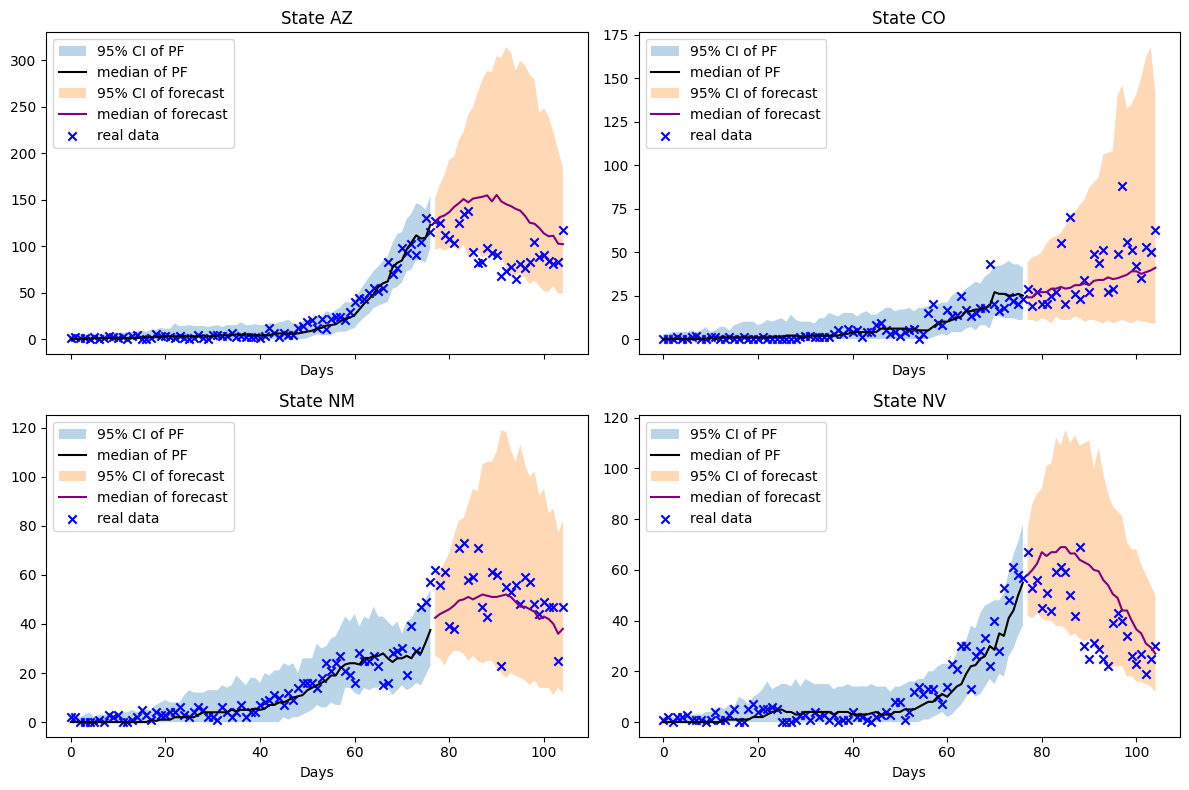

In [10]:
from math import ceil

n = len(states)
cols = 2
rows = ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()

data_date_range = np.arange(0,rume.time_frame.days,1)
sim_date_range = np.arange(rume.time_frame.days,rume.time_frame.days + extend_duration,1)
total_date_range = np.arange(0,rume.time_frame.days + extend_duration,1)

tf = TimeFrame.of("2022-09-15", 7 * cutoff_week + extend_duration).to_date_range().to_pandas()

for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')
    ax.set_xlabel('Days')

    lower_pf = np.percentile(particle_filter_output.events[:, :, i, 1], 2.5, axis=0).squeeze()
    upper_pf = np.percentile(particle_filter_output.events[:, :, i, 1], 97.5, axis=0).squeeze()
    mean_pf  = np.median(particle_filter_output.events[:, :, i, 1], axis=0).squeeze()

    lower_forecast = np.percentile(forecast_output.events[:, :, i, 1], 2.5, axis=0).squeeze()
    upper_forecast = np.percentile(forecast_output.events[:, :, i, 1], 97.5, axis=0).squeeze()
    mean_forecast  = np.median(forecast_output.events[:, :, i, 1], axis=0).squeeze()

    ax.fill_between(data_date_range, lower_pf, upper_pf, alpha=0.3, label='95% CI of PF')
    ax.plot(data_date_range, mean_pf, color='black', label='median of PF')

    ax.fill_between(sim_date_range, lower_forecast, upper_forecast, alpha=0.3, label='95% CI of forecast')
    ax.plot(sim_date_range, mean_forecast, color='purple', label='median of forecast')

    ax.scatter(total_date_range,df[(df['geoid'] == rume.scope.node_ids[i]) & df['date'].isin(tf)]['value1'],color = 'blue',marker = 'x',label = 'real data')

    ax.legend()

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig.tight_layout()

We can layer the particle filter and forecast to incorporate new data points. Let's examine how the particle filter performs when we incorporate the next week's data and forecast another four weeks ahead. 

In [11]:
extend_pf = 7 # Extend the filter by 7 days
particle_filter_simulator = EnsembleKalmanFilterSimulator(
        config=FromOutput(particle_filter_output,extend_pf),
        observations= observations,
        save_trajectories=True,
    )

In [12]:
particle_filter_output_update = particle_filter_simulator.run(rng=rng)

Observation: 6, Label: 2022-12-07, Time Frame: 2022-12-07 (1D)
Runtime with 200 members and 4 Nodes is 9.78 seconds.


- [ ] Rerun the forecast with the updated particle filter output. A key advantage of the particle filter is the online nature of the algorithm. To refine our particle filter estimate we need only start from the final output of the previous run. 

In [13]:
forecast_simulator = ForecastSimulator(FromOutput(particle_filter_output_update,extend_duration))

In [14]:
forecast_output_update = forecast_simulator.run(rng=rng)

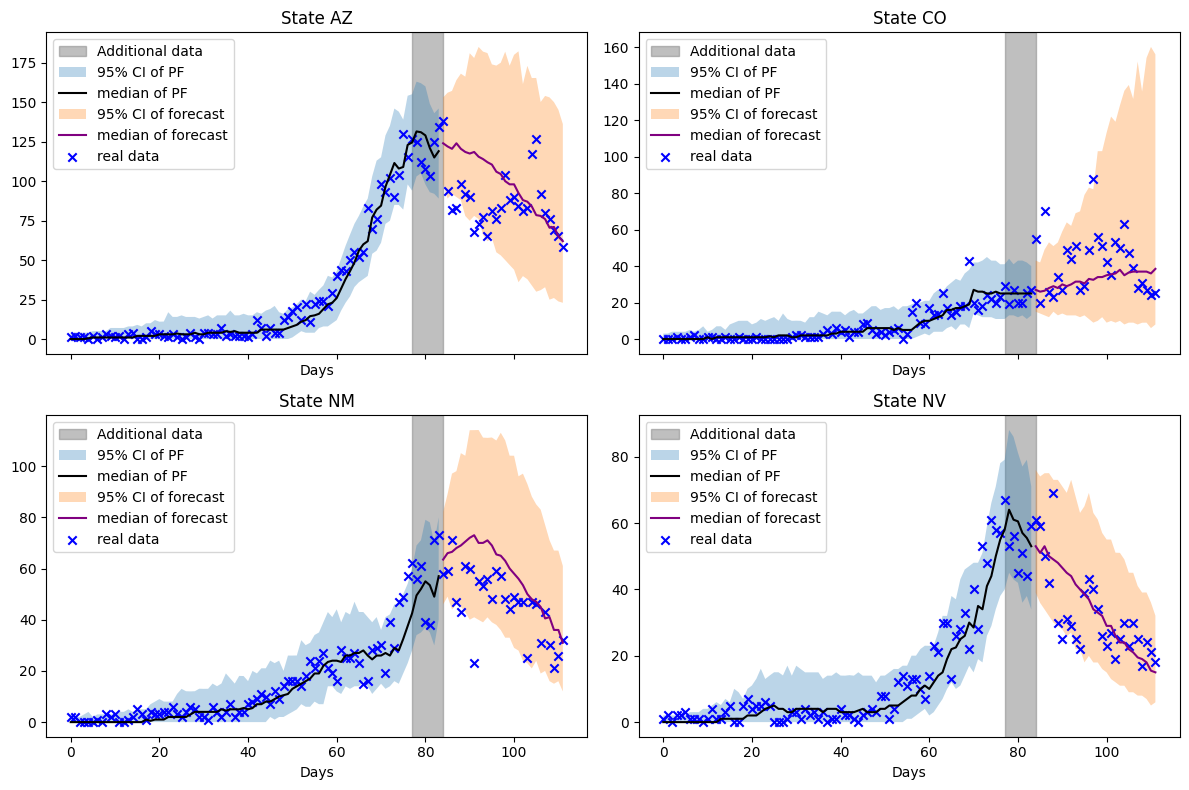

In [15]:
combined_particle_filter_events= np.concatenate((particle_filter_output.events,
                                                 particle_filter_output_update.events,),axis = 1)

n = len(states)
cols = 2
rows = ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()

data_date_range = np.arange(0,rume.time_frame.days + extend_pf,1)
sim_date_range = np.arange(rume.time_frame.days + extend_pf,rume.time_frame.days + extend_pf + extend_duration,1)
total_date_range = np.arange(0,rume.time_frame.days + extend_duration + extend_pf,1)

tf = TimeFrame.of("2022-09-15", 7 * cutoff_week + extend_pf + extend_duration).to_date_range().to_pandas()

for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')
    ax.set_xlabel('Days')

    lower_pf = np.percentile(combined_particle_filter_events[:, :, i, 1], 2.5, axis=0).squeeze()
    upper_pf = np.percentile(combined_particle_filter_events[:, :, i, 1], 97.5, axis=0).squeeze()
    median_pf  = np.median(combined_particle_filter_events[:, :, i, 1], axis=0).squeeze()

    lower_forecast = np.percentile(forecast_output_update.events[:, :, i, 1], 2.5, axis=0).squeeze()
    upper_forecast = np.percentile(forecast_output_update.events[:, :, i, 1], 97.5, axis=0).squeeze()
    median_forecast  = np.median(forecast_output_update.events[:, :, i, 1], axis=0).squeeze()

    ax.axvspan(rume.time_frame.days, rume.time_frame.days + extend_pf, alpha=0.5, color='gray',label = 'Additional data')

    ax.fill_between(data_date_range, lower_pf, upper_pf, alpha=0.3, label='95% CI of PF')
    ax.plot(data_date_range, median_pf, color='black', label='median of PF')

    ax.fill_between(sim_date_range, lower_forecast, upper_forecast, alpha=0.3, label='95% CI of forecast')
    ax.plot(sim_date_range, median_forecast, color='purple', label='median of forecast')

    ax.scatter(total_date_range,df[(df['geoid'] == rume.scope.node_ids[i]) & df['date'].isin(tf)]['value1'],color = 'blue',marker = 'x',label = 'real data')


    ax.legend()

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig.tight_layout()

## Notes

We see a narrowing of the forecast uncertainty as more data is assimilated by the filter. The downwards trajectory of hospitalizations is captured in 3 of the 4 states. Colorado's hospitalizations admissions exhibit sub-exponential growth which proves a challenge for this model. 